Continuing on my last post, I'd like to dive deeper into one piece of software in particular: PixInsight. This piece of software is developed specifically as a tool for astrophotography, and skilled use of it can lead to spectacular images. In contrast to software like Adobe Photoshop, PixInsight uses what it calls an "object-oriented interface and nonlinear workflow." In practice, what this means is that an images is edited using some number of discreet processes and scripts. Because of the requirements on /r/astrophotography that processing details are posted, we should be able to find which processes are most frequently used.

I start by getting the data and software information from before.

In [1]:
import praw
import numpy as np
import pandas as pd

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Restore from the CSV. To make things easier, I want to fill the comments with
# blanks instead of NaNs
df = pd.read_csv('data.csv')
df['first_op_comment'] = df['first_op_comment'].fillna(value='')

In [3]:
df['comment_tb'] = df['first_op_comment'].map(lambda x: TextBlob(x))
df['used_PI'] = df['comment_tb'].map(lambda x: (x.word_counts['pixinsight']+x.word_counts['pix']+x.word_counts['PI']) > 0 )
df['used_PS'] = df['comment_tb'].map(lambda x: (x.word_counts['photoshop']+x.word_counts['shop']+x.word_counts['ps']) > 0)
df['used_lightroom'] = df['comment_tb'].map(lambda x: x.word_counts['lightroom'] > 0)
df['used_DSS'] = df['comment_tb'].map(lambda x: (x.word_counts['dss'] + x.word_counts['deepskystacker']) > 0)
df['used_autostakkert'] = df['comment_tb'].map(lambda x: x.word_counts['autostakkert'] > 0)
df['used_registax'] = df['comment_tb'].map(lambda x: x.word_counts['registax'] > 0)

For this analysis, I'm just going to use Python's built in string parsing. To make this easier, I'm going to remove the spaces from each comment and then make it entirely lower case.

Next, I import a list of every process and script in PixInsight. Because I want to be able to distinguish between processes and scripts, I create a new column with this information.

In [4]:
df['op_comment_lower_no_space'] = df['first_op_comment'].map(lambda x: x.replace(' ','').lower())

In [5]:
processes = pd.read_csv('processes.csv',index_col='Name')
scripts = pd.read_csv('scripts.csv',index_col='Name')
processes['type'] = pd.Series(dtype=str)
processes['type'].fillna(value='Process',inplace=True)
objs = pd.concat([processes,scripts])
objs['type'].fillna(value='Script',inplace=True)

Now Python makes it easy to count how many times each process and script name appears in each comment! I include this as a new feature for each post, and then store the counts in the data frame of every process and script.

In [6]:
for name in objs.index:
    df['used_' + name] = df['op_comment_lower_no_space'].map(lambda x: name.lower() in x)
objs['count'] = objs.index.map(lambda x: sum(df['used_' + x]))
objs.sort_values('count',ascending=False,inplace=True)

In [7]:
objs

,type,count
Name,,
Crop,Process,2170
ColorCalibration,Process,770
HistogramTransformation,Process,707
Convolution,Process,684
SCNR,Process,675
Deconvolution,Process,671
BackgroundNeutralization,Process,574
CurvesTransformation,Process,543
DynamicCrop,Process,503


Nice! There are a few things that stand out that we should fix:

* Some processes have really common names, which doesn't necessarily mean that the post used that process. "Crop" is definitely in this category (in fact, this is often going to be double counted because the PixInsight process "DynamicCrop" is very common). Other things likely in this category are "Script" and "Invert."

* Some processes have common abbreviations which would not be counted using just the name. For these abbreviations I can go through and count them too.

* Finally, unlike in data science, astrophotographers rarely use convolution, but often use deconvolution!  because of the way we counted things, "convolution" is counted both when the poster says "convolution" or "deconvolution." I'll also check for any other cases like this to be safe.

This is where domain knowledge is important in data science. Because this is my hobby, I can work on fixing some of these issues.

Further, I'm going to drop any processes and scripts which don't show up at all. It's not surprising that there are a lot of these.

In [8]:
# Drop names that are too commmon
commonNames = ['Crop','Divide','Invert','NewImage','Preferences',
               'Resample','Rescale','Rotation','Script','Statistics']
objs.drop(commonNames,axis=0,inplace=True)
df.drop(map(lambda x: 'used_' + x,commonNames),axis=1,inplace=True)

In [9]:
# Check for one process contained in another:
containment = {}
for x in objs.index:
    for y in objs.index:
        if (x.lower() in y.lower()) and x != y:
            if x in containment.keys():
                containment[x].append(y)
            else:
                containment[x] = [y]

In [10]:
for process,containedList in containment.items():
    df['used_' + process] = df['used_' + process] & ~df.loc[:,map(lambda x: 'used_' + x,containedList)].any(axis=1)
    objs.loc[process,'count'] = sum(df['used_' + process])

In [11]:
# Include common process and script abbreviations. For this, I need to be careful.
# Counting in the same way as before, the abbreviation 'dbe' would be counted in this sentence
# (because we squeeze together 'would' and 'be'). So I'm going to look at the comments with
# spaces, but all in lower case.
df['op_comment_lower'] = df['first_op_comment'].map(lambda x: x.lower())
abbrevs = {
    'DynamicBackgroundExtraction' : 'dbe',
    'LocalHistogramEqualization' : 'lhe',
    'MultiscaleLinearTransform' : 'mlt',
    'MultiscaleMedianTransform' : 'mmt',
    'PhotometricColorCalibration' : 'pcc',
    'ScreenTransferFunction' : 'stf',
    'BatchPreprocessing' : 'bpp',
    
}

for name,abbrev in abbrevs.items():
    df['used_' + name] = df['used_' + name] | df['op_comment_lower'].map(lambda x: abbrev in x)
    objs.loc[name,'count'] = sum(df['used_' + name])
    
objs.sort_values('count',ascending=False,inplace=True)

In [12]:
# Finally, remove all scripts and processes with zero mentions
df.drop(map(lambda x: 'used_' + x,objs[objs['count'] == 0].index),axis=1,inplace=True)
objs = objs[objs['count']>0]

In [13]:
objs.head(20)

,type,count
Name,,
DynamicBackgroundExtraction,Process,885
HistogramTransformation,Process,707
SCNR,Process,675
ColorCalibration,Process,672
Deconvolution,Process,671
LocalHistogramEqualization,Process,593
BackgroundNeutralization,Process,574
CurvesTransformation,Process,543
DynamicCrop,Process,503


And there we have it! The 20 most used PixInsight processes on /r/astrophotography! Looking over the list as a sanity check, it seems reasonably accurate. However, I do suspect there are some problems. For example, someone could say "Adjusted the histogram in PixInsight." They would certainly use the HistogramTransformation process to do this, but our methods didn't capture that. Still, this gives insight into what processes are commonly used. Because graphics always help, let's turn this data into a plot.

Text(0.5,1,'20 Most Used PixInsight Processes and Scripts on /r/astrophotography')

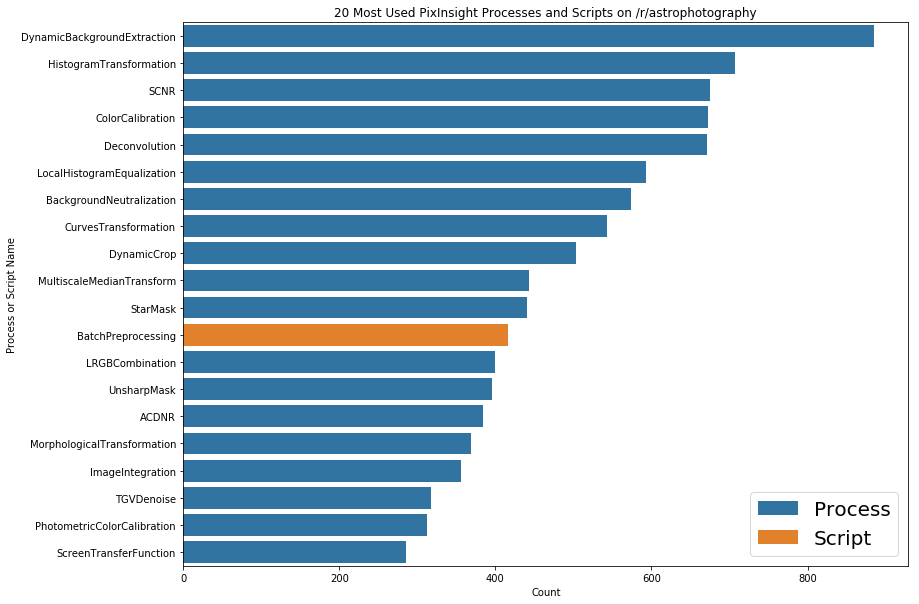

In [14]:
plt.figure(figsize=(13,10))
g=sns.barplot(y=objs.head(20).index,x=objs.head(20)['count'],hue=objs.head(20)['type'],dodge=False)
plt.legend(prop={'size': 20})
plt.xlabel('Count')
plt.ylabel('Process or Script Name')
plt.title('20 Most Used PixInsight Processes and Scripts on /r/astrophotography')